<a href="https://colab.research.google.com/github/smallriver0316/python-datascience-study/blob/development/gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [4]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
# flip axes for better plotting
X = X[:, ::-1]

In [6]:
# k平均法モデルによる円形クラスタを可視化
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
  labels = kmeans.fit_predict(X)
  # plot the input data
  ax = ax or plt.gca()
  ax.axis('equal')
  ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
  # plot the representation of the k-means model
  centers = kmeans.cluster_centers_
  radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
  for c, r in zip(centers, radii):
    ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

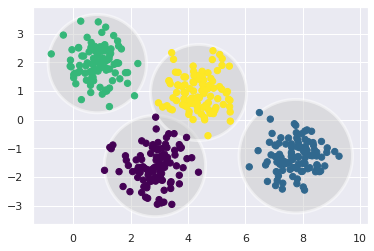

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

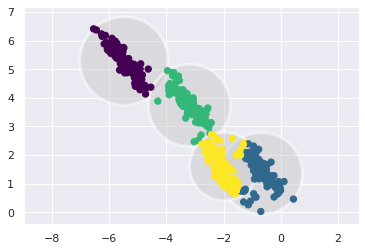

In [9]:
# k平均法の問題点としてクラスタは円形でなければならないという制約がある
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

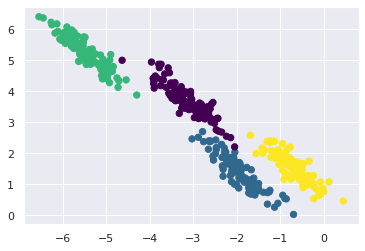

In [13]:
# ガウス混合モデル(GMM: Gaussian Mixture Models)
# 入力データセットを最もよくモデル化する多次元のガウス確率分布の重ね合わせを見つける
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X_stretched)
labels=gmm.predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='viridis')

In [14]:
# 各点が各クラスタに属する確率
probs = gmm.predict_proba(X_stretched)
print(probs[:5].round(3))

[[0.575 0.    0.425 0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]]


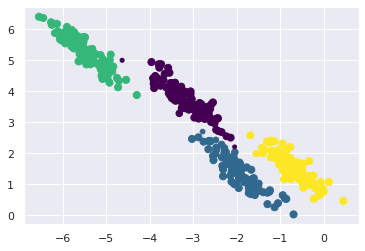

In [15]:
# 不確実性の可視化
# square emphasizes differences
size = 50 * probs.max(1) ** 2
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, cmap='viridis', s=size)

In [18]:
# GMMクラスタの位置と境界の可視化
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
  ax = ax or plt.gca()
  # Convert covariance to principal axes
  if covariance.shape == (2, 2):
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
  else:
    angle = 0
    width, height = 2 * np.sqrt(s)
  # Draw the ellipse
  for nsig in range(1, 4):
    ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
  ax = ax or plt.gca()
  labels = gmm.fit(X).predict(X)
  if label:
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
  else:
    ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
  ax.axis('equal')

  w_factor = 0.2 / gmm.weights_.max()
  for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)

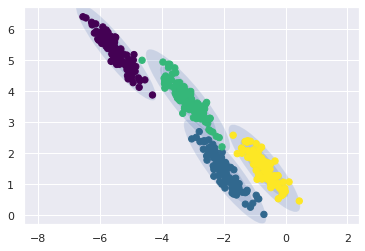

In [19]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X_stretched)

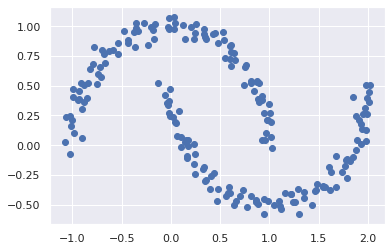

In [20]:
# GMMによる密度推定
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

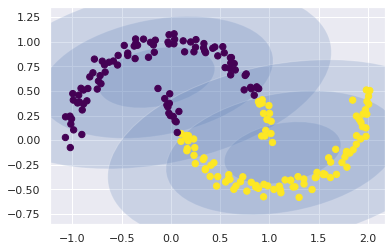

In [21]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

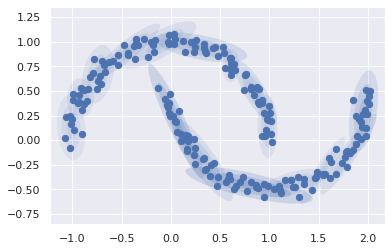

In [23]:
# より細かいクラスタに分割するようにすれば、非線形なデータにも当てはめられる(ただし16分割されてしまう)
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

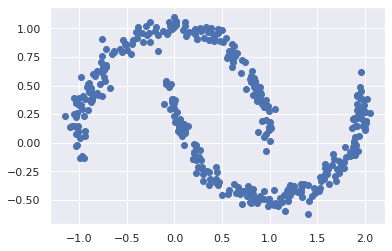

In [25]:
# 学習済みのGMMのモデルから分布を表現する
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

Text(0.5, 0, 'n_components')

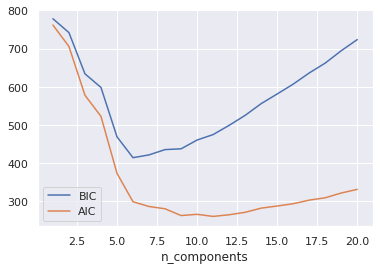

In [27]:
# 最適な成分数の決定
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0, reg_covar=0.001).fit(Xmoon) for n in n_components]
# BIC: ベイズ情報量基準
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
# AIC: 赤池情報量基準
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

- BICより6が最適な成分数
- AICだと8~12
- 典型的にBICの方がよりシンプルなモデルを推奨する
- AIC, BICどちらにしても16は多すぎる

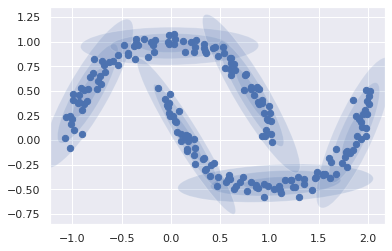

In [28]:
gmm6 = GaussianMixture(n_components=6, covariance_type='full', random_state=0)
plot_gmm(gmm6, Xmoon, label=False)

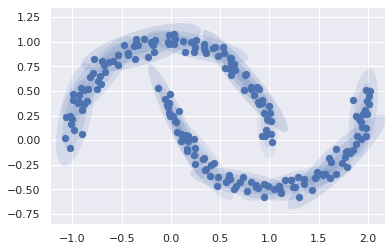

In [29]:
gmm12 = GaussianMixture(n_components=12, covariance_type='full', random_state=0)
plot_gmm(gmm12, Xmoon, label=False)

12ぐらいが適当そう